In [2]:
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
import pickle 
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
import math

from scipy.optimize import curve_fit



C:\Users\lucys\AppData\Local\Temp\ipykernel_25592\3393214177.py:2: DeprecationWarning: Please use `readsav` from the `scipy.io` namespace, the `scipy.io.idl` namespace is deprecated.
  from scipy.io.idl import readsav


In [3]:
path = '2355-534_HCOp.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
print("Shape of Array:")
print(data.shape)
header = cube[0].header

Shape of Array:
(1, 1918, 420, 420)


In [4]:
print(header[1:50])

BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                  420                                                  NAXIS2  =                  420                                                  NAXIS3  =                 1918                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   5.832647142677E-04                                                  BMIN    =   4.652447706073E-04                                                  BPA     =  -7.174725489164E+01                                                  BTYPE   = 'Intensity'                   

In [5]:
print('Axis 1 is {:8s}'.format(header["CTYPE1"]))
print('Axis 2 is {:8s}'.format(header["CTYPE2"]))
print('Axis 3 is {:8s}'.format(header["CTYPE3"]))
print('Axis 4 is {:8s}'.format(header["CTYPE4"]))

Axis 1 is RA---SIN
Axis 2 is DEC--SIN
Axis 3 is FREQ    
Axis 4 is STOKES  


In [6]:
path = 'J0253-5441.fits'
cube = fits.open(path)
data = cube[0].data
print(data.shape)
header = cube[0].header

image = np.squeeze(data)

maxindex = np.unravel_index(image.argmax(), image.shape)
print(np.where(image == np.nanmax(image)))
print(maxindex)

ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

print('RA Coordinate:')
#print(ra[maxindex[0]])
print(ra[512])

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)

print('DEC Coordinate:')
#print(dec[maxindex[1]])
print(dec[512])

(1, 1, 1024, 1024)
(array([512], dtype=int64), array([512], dtype=int64))
(0, 0)
RA Coordinate:
43.371585
DEC Coordinate:
-54.69762111111


In [7]:
points = np.where(image>0.9*np.nanmax(image))
print(points)

(array([511, 511, 512, 512], dtype=int64), array([512, 513, 512, 513], dtype=int64))


In [36]:
def integrated_optical_depth(source = 'NGC7469', molecule1 = 'HCOp', molecule2 = 'HCN', molecule3 = 'CCH', molecule4 = 'HNC'):
    
    #Start off by finding the continuum flux density
    path = source + '_' + molecule1 + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    integrated = np.sum(squeezed_data[:, :, :], axis = 0)
    max_val = np.nanmax(integrated)
    x, y = np.where(integrated == np.nanmax(integrated))
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*(1 - (frequency/i_frequency)))/1000
    velocity = np.array(velocity, dtype = float)
    velocity_diff = velocity[1]- velocity[0]
    #print(velocity)
    
    #Defining the brightest pixels
    x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1
    
    #Defining the brightest pixel for each point source based on previous findings
    if source == '2331p073':
        array = np.arange(0, 1918, 1)
    elif source == 'J0635-7516':
        array = np.arange(0, 1918, 1)
    elif source == '2355-534':
        array = np.arange(0, 1918, 1)
    elif source == 'J1058-8003':
        array = np.arange(0, 1918, 1)
    elif source == 'J0454-8101':
        array = np.arange(0, 850, 1)
    elif source == '2345-167':
        array = np.arange(0, 1900, 1)
    elif source == 'J2230+114':
        array = np.arange(1100, 1200, 1)
    elif source == 'J0049-4457':
        array = np.arange(700, 850, 1)

    spectrum = squeezed_data[:, y1, x1]

    decimated_xvals = (velocity[array])[::10]
    x = decimated_xvals[1:]
    
    entau = spectrum/np.mean(spectrum[0:100])
    #This is the e^-tau spectrum, so get tau first, then integrate
    
    tau = -np.log(entau)
    
    smoothing_6 = convolve(tau, Box1DKernel(3))
    smoothed_decimated_spect = smoothing_6[::3]
    new_tau = smoothed_decimated_spect[3:]
    decimated_xvals = velocity[::3]
    velocity = decimated_xvals[3:]
    
    plt.figure(figsize=[8,12])
    plt.plot(velocity, new_tau, label = r'HCO$^{+}$ Optical Depth Spectrum', color = 'green')
    
    ###############################################################################################################
    
    path = source + '_' + molecule2 + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    integrated = np.sum(squeezed_data[:, :, :], axis = 0)
    max_val = np.nanmax(integrated)
    x, y = np.where(integrated == np.nanmax(integrated))
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*(1 - (frequency/i_frequency)))/1000
    velocity = np.array(velocity, dtype = float)
    velocity_diff = velocity[1]- velocity[0]
    #print(velocity)
    
    #Defining the brightest pixels
    x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1
    
    #Defining the brightest pixel for each point source based on previous findings
    if source == '2331p073':
        array = np.arange(0, 1918, 1)
    elif source == 'J0635-7516':
        array = np.arange(0, 1918, 1)
    elif source == '2355-534':
        array = np.arange(0, 1918, 1)
    elif source == 'J1058-8003':
        array = np.arange(0, 1918, 1)
    elif source == 'J0454-8101':
        array = np.arange(0, 850, 1)
    elif source == '2345-167':
        array = np.arange(0, 1900, 1)
    elif source == 'J2230+114':
        array = np.arange(1100, 1200, 1)
    elif source == 'J0049-4457':
        array = np.arange(700, 850, 1)

    spectrum = squeezed_data[:, y1, x1]

    decimated_xvals = (velocity[array])[::10]
    x = decimated_xvals[1:]
    
    entau = spectrum/np.mean(spectrum[0:100])
    #This is the e^-tau spectrum, so get tau first, then integrate
    
    tau = -np.log(entau)
    
    smoothing_6 = convolve(tau, Box1DKernel(3))
    smoothed_decimated_spect = smoothing_6[::3]
    new_tau = smoothed_decimated_spect[3:]
    decimated_xvals = velocity[::3]
    velocity = decimated_xvals[3:]
    
    plt.plot(velocity, new_tau+0.07, label = 'HCN Optical Depth Spectrum', color = 'blue')
    
    ###################################################################################################################
    
    path = source + '_' + molecule3 + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    integrated = np.sum(squeezed_data[:, :, :], axis = 0)
    max_val = np.nanmax(integrated)
    x, y = np.where(integrated == np.nanmax(integrated))
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*(1 - (frequency/i_frequency)))/1000
    velocity = np.array(velocity, dtype = float)
    velocity_diff = velocity[1]- velocity[0]
    #print(velocity)
    
    #Defining the brightest pixels
    x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1
    
    #Defining the brightest pixel for each point source based on previous findings
    if source == '2331p073':
        array = np.arange(0, 1918, 1)
    elif source == 'J0635-7516':
        array = np.arange(0, 1918, 1)
    elif source == '2355-534':
        array = np.arange(0, 1918, 1)
    elif source == 'J1058-8003':
        array = np.arange(0, 1918, 1)
    elif source == 'J0454-8101':
        array = np.arange(0, 850, 1)
    elif source == '2345-167':
        array = np.arange(0, 1900, 1)
    elif source == 'J2230+114':
        array = np.arange(1100, 1200, 1)
    elif source == 'J0049-4457':
        array = np.arange(700, 850, 1)

    spectrum = squeezed_data[:, y1, x1]

    decimated_xvals = (velocity[array])[::10]
    x = decimated_xvals[1:]
    
    entau = spectrum/np.mean(spectrum[0:100])
    #This is the e^-tau spectrum, so get tau first, then integrate
    
    tau = -np.log(entau)
    
    smoothing_6 = convolve(tau, Box1DKernel(3))
    smoothed_decimated_spect = smoothing_6[::3]
    new_tau = smoothed_decimated_spect[3:]
    decimated_xvals = velocity[::3]
    velocity = decimated_xvals[3:]
    
    plt.plot(velocity, new_tau+0.14, label = r'C$_2$H Optical Depth Spectrum', color = 'purple')
    
    ###################################################################################################################
    
    path = source + '_' + molecule4 + '.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header
    
    squeezed_data = data[0, :, :, :]
    
    integrated = np.sum(squeezed_data[:, :, :], axis = 0)
    max_val = np.nanmax(integrated)
    x, y = np.where(integrated == np.nanmax(integrated))
    
    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)
    
    #Converting from Frequeny to Velocity
    frequency_start = header["CRVAL3"]
    frequency_inc = header["CDELT3"]

    channels2 = np.arange(header["NAXIS3"])

    frequency = frequency_start + (frequency_inc * channels2)
    #frequency = np.array(frequency, dtype = float)

    i_frequency = header["RESTFRQ"]
    velocity = (3E8*(1 - (frequency/i_frequency)))/1000
    velocity = np.array(velocity, dtype = float)
    velocity_diff = velocity[1]- velocity[0]
    #print(velocity)
    
    #Defining the brightest pixels
    x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
    y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1
    
    #Defining the brightest pixel for each point source based on previous findings
    if source == '2331p073':
        array = np.arange(0, 1918, 1)
    elif source == 'J0635-7516':
        array = np.arange(0, 1918, 1)
    elif source == '2355-534':
        array = np.arange(0, 1918, 1)
    elif source == 'J1058-8003':
        array = np.arange(0, 1918, 1)
    elif source == 'J0454-8101':
        array = np.arange(0, 850, 1)
    elif source == '2345-167':
        array = np.arange(0, 1900, 1)
    elif source == 'J2230+114':
        array = np.arange(1100, 1200, 1)
    elif source == 'J0049-4457':
        array = np.arange(700, 850, 1)

    spectrum = squeezed_data[:, y1, x1]

    decimated_xvals = (velocity[array])[::10]
    x = decimated_xvals[1:]
    
    entau = spectrum/np.mean(spectrum[0:100])
    #This is the e^-tau spectrum, so get tau first, then integrate
    
    tau = -np.log(entau)
    
    smoothing_6 = convolve(tau, Box1DKernel(3))
    smoothed_decimated_spect = smoothing_6[::3]
    new_tau = smoothed_decimated_spect[3:]
    decimated_xvals = velocity[::3]
    velocity = decimated_xvals[3:]
    
    plt.plot(velocity, new_tau+0.21, label = 'HNC Optical Depth Spectrum', color = 'orange')
    
    ###################################################################################################################
    
    if source == '2331p073':
        g_path = 'GALFA_HI_RA+DEC_356.00+10.35_W.fits'
    elif source == 'J2230+114':
        g_path = 'GALFA_HI_RA+DEC_340.00+10.35_W.fits'
    else:
        g_path = source + '_GASS.fits'

    g_cube = fits.open(g_path)
    g_data = g_cube[0].data
    g_header = g_cube[0].header

    g_ra_start = g_header["CRVAL1"]
    g_ra_inc = g_header["CDELT1"]

    g_channels = np.arange(g_header["NAXIS1"]) - g_header["CRPIX1"]+1

    g_ra = g_ra_start + (g_ra_inc * g_channels)
    g_ra = np.array(g_ra, dtype = float)

    g_dec_start = g_header["CRVAL2"]
    g_dec_inc = g_header["CDELT2"]

    g_channels1 = np.arange(g_header["NAXIS2"]) - g_header["CRPIX2"]+1

    g_dec = g_dec_start + (g_dec_inc * g_channels1)
    g_dec = np.array(g_dec, dtype = float)

    g_velocity_start = g_header["CRVAL3"]
    g_velocity_inc = g_header["CDELT3"]
    print(g_velocity_inc)

    g_channels2 = np.arange(g_header["NAXIS3"])-g_header["CRPIX3"]+1

    g_velocity = g_velocity_start + (g_velocity_inc * g_channels2)
    g_velocity_kms = g_velocity/1000
    #print(g_velocity_kms[0], g_velocity_kms[-1])

    #Here we find the corresponding pixels for the brightest point in HCO+ in the GALFA data
    y_array = np.abs(g_dec-dec[y1])
    g_y = y_array.argmin()
    x_array = np.abs(g_ra-ra[x1])
    g_x = x_array.argmin()

    g_x1 = g_x - 10
    g_x2 = g_x + 10
    g_y1 = g_y - 10
    g_y2 = g_y + 10

    if source == '2331p073' or source == 'J2230+114':
        g_data2 = g_data[:, :, np.arange(g_x1, g_x2)]
        g_data3 = g_data2[:, np.arange(g_y1, g_y2), :]

        g_rng=range(len(g_velocity_kms))
        g_spectrum = []
        for i in g_rng:
            g_spectrum += [np.nansum(g_data3[i,:,:])*g_velocity_inc]
    else:
        g_rng=range(len(g_velocity_kms))
        g_spectrum = []
        for i in g_rng:
            g_spectrum += [np.nansum(g_data[i,:,:])*g_velocity_inc]

    #Now we have to find the corresponding velocity channels for HI and HCO+
    g_vel_1 = np.abs(g_velocity_kms - velocity[0])
    g_vel_min = g_vel_1.argmin()
    #print(g_vel_min)
    g_vel_2 = np.abs(g_velocity_kms - velocity[-1])
    g_vel_max = g_vel_2.argmin()
    #print(g_vel_max)

    g_vel_chans = np.arange(g_vel_min, g_vel_max, 1, dtype = int)
    #g_vel_chans = np.linspace(g_vel_min, g_vel_max, g_vel_max-g_vel_min + 1)
    g_vel_kms = g_velocity_kms[g_vel_chans]

    g_spect = g_spectrum[g_vel_min:g_vel_max]

    g_spect = [x/3e5 for x in g_spect]
    g_y_vals = [x+0.28 for x in g_spect]

    def gauss_function(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    popt, pcov = curve_fit(gauss_function, g_vel_kms, g_spect, p0 = [0.1, 260, 12])
    print(popt)
    #popt = [0.1, 260, 12]

    x0 = np.arange(velocity[0], velocity[-1], 1)

    plt.plot(x0,gauss_function(x0, *popt) + 0.28, color = 'red')
    plt.plot(g_vel_kms, g_y_vals, label = 'GASS HI Emission Spectrum', color = 'red', alpha = 0.6)

    plt.vlines(popt[1], ymin = -0.01, ymax = 0.12, colors = 'black', linestyles = 'dashed')

    plt.xlabel('Velocity (km/s)', fontsize = 16)
    plt.ylabel(r'Optical Depth ($\tau$)', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    #plt.title('Optical Depth Spectrum '+ source + ' for ' + molecule, fontsize=16)
    plt.legend(loc = 1)
    plt.ylim(top = 0.38)
    plt.grid()
    
    #plt.savefig(source + 'final.png', bbox_inches='tight')

824.45578043
[8.02682000e-02 2.49775617e+02 1.80878510e+01]


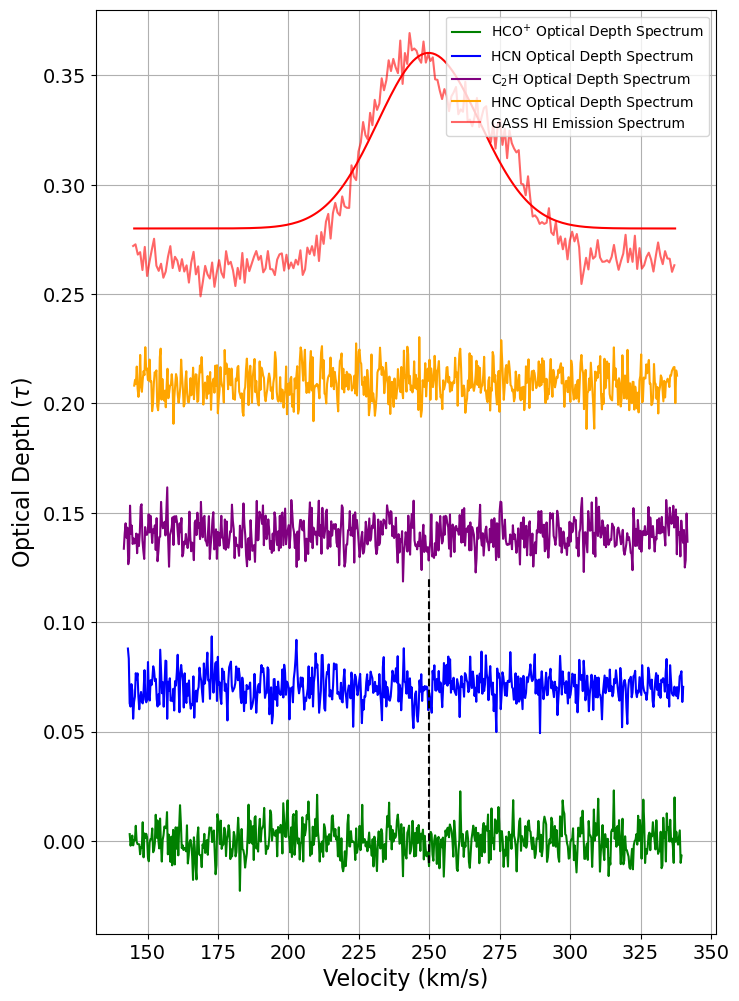

In [37]:
integrated_optical_depth(source = 'J0635-7516', molecule1 = 'HCOp', molecule2 = 'HCN', molecule3 = 'CCH', molecule4 = 'HNC')

736.1228396
451
724
[451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468
 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486
 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576
 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594
 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612
 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630
 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648
 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666
 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684
 685 686 687 688 689 690 691 69

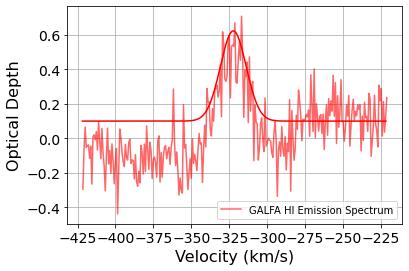

In [53]:
source = 'J2230+114'
molecule3 = 'CCH'

path = source + '_' + molecule3 + '.pbcor.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
squeezed_data = data[0, :, :, :]

integrated = np.sum(squeezed_data[:, :, :], axis = 0)
max_val = np.nanmax(integrated)
x, y = np.where(integrated == np.nanmax(integrated))

ra_start = header["CRVAL1"]
ra_inc = header["CDELT1"]

channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1
ra = ra_start + (ra_inc * channels)
ra = np.array(ra, dtype = float)

dec_start = header["CRVAL2"]
dec_inc = header["CDELT2"]

channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

dec = dec_start + (dec_inc * channels1)
dec = np.array(dec, dtype = float)

#Converting from Frequeny to Velocity
frequency_start = header["CRVAL3"]
frequency_inc = header["CDELT3"]

channels2 = np.arange(header["NAXIS3"])

frequency = frequency_start + (frequency_inc * channels2)
#frequency = np.array(frequency, dtype = float)

i_frequency = header["RESTFRQ"]
velocity = (3E8*(1 - (frequency/i_frequency)))/1000
velocity = np.array(velocity, dtype = float)
velocity_diff = velocity[1]- velocity[0]
#print(velocity)

#Defining the brightest pixels
x1 = round(header["CRPIX1"]-(ra_start-float(ra[x]))/ra_inc)-1
y1 = round(header["CRPIX2"]-(dec_start-float(dec[y]))/dec_inc)-1

#Defining the brightest pixel for each point source based on previous findings
#if source == '2331p073':
    #array = np.arange(0, 1918, 1)
#elif source == 'J0635-7516':
    #array = np.arange(0, 1918, 1)
#elif source == '2355-534':
    #array = np.arange(0, 1918, 1)
#elif source == 'J1058-8003':
    #array = np.arange(0, 1918, 1)
#elif source == 'J0454-8101':
    #array = np.arange(0, 850, 1)
#elif source == '2345-167':
    #array = np.arange(0, 1900, 1)
#elif source == 'J2230+114':
    #array = np.arange(1100, 1200, 1)
#elif source == 'J0049-4457':
    #array = np.arange(700, 850, 1)

#spectrum = squeezed_data[:, y1, x1]

#decimated_xvals = (velocity[array])[::10]
#x = decimated_xvals[1:]

#entau = spectrum/np.mean(spectrum[0:100])
#This is the e^-tau spectrum, so get tau first, then integrate

#tau = -np.log(entau)

#smoothing_6 = convolve(tau, Box1DKernel(3))
#smoothed_decimated_spect = smoothing_6[::3]
#new_tau = smoothed_decimated_spect[3:]
#decimated_xvals = velocity[::3]
#velocity = decimated_xvals[3:]

#plt.plot(velocity, new_tau+0.08, label = 'HNC Optical Depth Spectrum', color = 'orange')

###################################################################################################################

if source == '2331p073':
    coord = '356.00+10.35'
elif source == 'J2230+114':
    coord = '340.00+10.35'

g_path = 'GALFA_HI_RA+DEC_' + coord + '_W.fits'
g_cube = fits.open(g_path)
g_data = g_cube[0].data
g_header = g_cube[0].header

g_ra_start = g_header["CRVAL1"]
g_ra_inc = g_header["CDELT1"]

g_channels = np.arange(g_header["NAXIS1"]) - g_header["CRPIX1"]+1

g_ra = g_ra_start + (g_ra_inc * g_channels)
g_ra = np.array(g_ra, dtype = float)

g_dec_start = g_header["CRVAL2"]
g_dec_inc = g_header["CDELT2"]

g_channels1 = np.arange(g_header["NAXIS2"]) - g_header["CRPIX2"]+1

g_dec = g_dec_start + (g_dec_inc * g_channels1)
g_dec = np.array(g_dec, dtype = float)

g_velocity_start = g_header["CRVAL3"]
g_velocity_inc = g_header["CDELT3"]
print(g_velocity_inc)

g_channels2 = np.arange(g_header["NAXIS3"])-g_header["CRPIX3"]+1

g_velocity = g_velocity_start + (g_velocity_inc * g_channels2)
g_velocity_kms = g_velocity/1000
#print(g_velocity_kms[0], g_velocity_kms[-1])

#Here we find the corresponding pixels for the brightest point in HCO+ in the GALFA data
y_array = np.abs(g_dec-dec[y1])
g_y = y_array.argmin()
x_array = np.abs(g_ra-ra[x1])
g_x = x_array.argmin()

g_x1 = g_x - 10
g_x2 = g_x + 10
g_y1 = g_y - 10
g_y2 = g_y + 10

g_data2 = g_data[:, :, np.arange(g_x1, g_x2)]
g_data3 = g_data2[:, np.arange(g_y1, g_y2), :]

g_rng=range(len(g_velocity_kms))
g_spectrum = []
for i in g_rng:
    g_spectrum += [np.nansum(g_data3[i,:,:])*g_velocity_inc]

#Now we have to find the corresponding velocity channels for HI and HCO+
g_vel_1 = np.abs(g_velocity_kms - velocity[0])
g_vel_min = g_vel_1.argmin()
#print(g_vel_min)
g_vel_2 = np.abs(g_velocity_kms - velocity[-1])
g_vel_max = g_vel_2.argmin()
#print(g_vel_max)

g_vel_chans = np.arange(g_vel_min, g_vel_max, 1, dtype = int)
#g_vel_chans = np.linspace(g_vel_min, g_vel_max, g_vel_max-g_vel_min + 1)
g_vel_kms = g_velocity_kms[g_vel_chans]

g_spect = g_spectrum[g_vel_min:g_vel_max]

g_spect = [x/60000 for x in g_spect]

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt, pcov = curve_fit(gauss_function, g_vel_kms, g_spect, p0 = [0.05, -330, 5])

x0 = np.arange(velocity[0], velocity[-1], 1)

plt.plot(x0,gauss_function(x0, *popt) + 0.1, color = 'red')
plt.plot(g_vel_kms, g_spect, label = 'GALFA HI Emission Spectrum', color = 'red', alpha = 0.6)
#plt.plot(g_velocity_kms, g_spectrum)

#plt.vlines(popt[1], ymin = -0.01, ymax = 0.1, colors = 'black', linestyles = 'dashed')

plt.xlabel('Velocity (km/s)', fontsize = 16)
plt.ylabel('Optical Depth', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
#plt.title('Optical Depth Spectrum '+ source + ' for ' + molecule, fontsize=16)
plt.legend()
plt.grid()
